In this tutorial we will be introducing the Graph Attention Autoencoder, which makes use of graph attention mechanisms for graph message passing during the encoding and decoding of our node features (expression profiles). This is the same architecture used in the popular STAGATE method. 

# Graph Attention Update: A Brief Summary

In a graph attention network, each node’s new feature vector is computed by aggregating its own transformed features with those of its neighbors, where each contribution is weighted by a learned attention coefficient.

## Node Feature Update

In keeping with the notation from their paper, for a given node $i$, the update is given by:

$ \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j} $

- $\mathbf{\Theta}$ is a learnable weight matrix that transforms the input features.
- $\mathcal{N}(i)$ denotes the set of spatial neighbors of node $i$ (i.e. the spatial graph structure).
- The term $\alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i}$ represents the self-loop, ensuring that node $i$’s own features contribute to its update.
- $\alpha_{i,j}$ is the attention coefficient, which determines the importance of the features from neighbor $j$ in updating node $i$ (i.e. how much should the features of a spatial neighbor node $j$ contribute to constructing the embedding of node $i$).

## Attention Coefficient Computation

The attention coefficients $\alpha_{i,j}$ are computed as follows:

$ \alpha_{i,j} = \frac{ \exp\Big(\mathrm{LeakyReLU}\Big(\mathbf{a}^{\top} \big[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j\big]\Big)\Big)} { \sum_{k \in \mathcal{N}(i) \cup \{ i \}} \exp\Big(\mathrm{LeakyReLU}\Big(\mathbf{a}^{\top} \big[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k\big]\Big)\Big)} $

- $\mathbf{a}$ is a learnable vector used to compute a compatibility score between nodes.
- The notation $\Vert$ denotes concatenation of the transformed features.
- The LeakyReLU activation introduces non-linearity before the scores are exponentiated.
- The softmax normalization (denominator) ensures that the attention coefficients sum to 1 across node $i$’s neighborhood (including itself).

## Summary

This formulation enables the network to learn which neighbors are most relevant when updating a node’s representation. By dynamically weighting each neighbor’s contribution based on feature similarity and learned parameters, the model can focus on the most informative parts of the graph structure, leading to more expressive node embeddings.


 The following code block implements a graph convolution layer that uses attention to weigh contributions from neighboring nodes.

- **Key Features**:  
  - Multi-head attention.
  - Optional concatenation or averaging of heads.
  - Use of self-loops and dropout in attention coefficients.
  - Supports separate transformations for source and target nodes if needed.

---

## Constructor (`__init__`)

- **Parameters**:
  - `in_channels`: Dimensionality of the input features (or a tuple for source and target features).
  - `out_channels`: Dimensionality of the output features.
  - `heads`: Number of attention heads (default is 1).
  - `concat`: If `True`, outputs from attention heads are concatenated; otherwise, they are averaged.
  - `negative_slope`: Negative slope parameter for the LeakyReLU used in attention computation (default is 0.2).
  - `dropout`: Dropout rate applied to the attention coefficients (default is 0.0).
  - `add_self_loops`: If `True`, self-loops are added to the graph (default is `True`).
  - `bias`: If `True`, an additive bias is included in the layer (default is `True`).

The code makes several references to source vs target nodes. In our context, source nodes are the nodes from which information (or messages) is sent. When processing an edge, the source node provides the features that will be weighted and passed along to its neighbors. Target nodes are the nodes that receive messages from their neighbors. For each edge, the target node aggregates the messages sent from its connected source nodes.

- **Initialization**:
  - **Linear Transformations**:  
    The source node features are transformed using a learned weight matrix (`lin_src`), which is also reused for target nodes (`lin_dst`).
  - **Attention Parameters**:  
    Two sets of learnable parameters (`att_src` and `att_dst`) are initialized to compute attention coefficients for source and target nodes.
  - **Weight Initialization**:  
    Xavier normal initialization is applied to both the linear transformation and attention parameters.
  - **Aggregation Method**:  
    The base class is configured to sum messages (`aggr='add'`).

---

## Forward Pass (`forward` Method)

- **Inputs**:
  - `x`: Node feature matrix (or a tuple for separate source and target features) (i.e. expression profiles for each spot).
  - `edge_index`: Graph connectivity in edge list format. (i.e. spatial relations in our context)
  - Optional flags:  
    - `return_attention_weights`: If set, returns the computed attention weights along with the output.
    - `attention` and `tied_attention`: Control how attention coefficients are computed or reused.

- **Processing Steps**:
  1. **Feature Transformation**:  
     Node features are transformed by multiplying with the linear transformation (`lin_src`), and reshaped to separate attention heads.
  
  2. **Attention Coefficient Computation**:  
     - For source nodes: Multiply transformed features by `att_src` and sum over the feature dimension.
     - For target nodes: Similar computation using `att_dst` (if available).
     - Optionally, tied attention values can be provided.
  
  3. **Self-Loop Handling**:  
     Self-loops are added to the graph to ensure every node has at least one connection (if enabled, in our context, every spot has a spatial neighbor).
  
  4. **Message Passing**:  
     The `propagate` method is called, which internally uses the computed attention coefficients to weigh neighbor contributions.
  
  5. **Aggregation of Heads**:  
     The outputs from multiple attention heads are either concatenated or averaged based on the `concat` flag.
  
  6. **Output**:  
     The final output is returned, and if requested, the attention weights are also provided.

---

## Message Function (`message` Method)

- **Purpose**:  
  Computes the messages passed from neighboring nodes to a target node, scaling the messages by learned attention coefficients.

- **Steps**:
  1. **Combine Attention Coefficients**:  
     Sums the coefficients from the source and target nodes.
  
  2. **Normalization**:  
     Applies a sigmoid activation and then softmax to normalize the attention coefficients over the neighbors.
  
  3. **Dropout**:  
     Applies dropout to the attention coefficients during training.
  
  4. **Message Computation**:  
     Multiplies the neighbor node features (`x_j`) by the normalized attention weights to scale the messages.

---

## Summary

The `GATConv` layer integrates:
- **Linear Transformations**: To project node features into a new space.
- **Attention Mechanism**: To compute weights that indicate the importance of each neighbor.
- **Message Passing**: To aggregate information from neighbors based on these weights.

This design allows the network to focus on the most relevant parts of the graph during learning, making it a more powerful approach than the previous GCN networks we've seen

---


In [1]:
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter
import torch.nn as nn
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax



class GATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        # intitialize parameters, such as dimensions of the hidden layers, 
        ## number of attention heads, whether to concatenate outputs, whether to include a bias term, and dropout rate
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        self.lin_src = nn.Parameter(torch.zeros(size=(in_channels, out_channels)))
        nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
        self.lin_dst = self.lin_src


        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        nn.init.xavier_normal_(self.att_src.data, gain=1.414)
        nn.init.xavier_normal_(self.att_dst.data, gain=1.414)
        self._alpha = None
        self.attentions = None

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None, attention=True, tied_attention = None):
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            # x_src = x_dst = self.lin_src(x).view(-1, H, C)
            x_src = x_dst = torch.mm(x, self.lin_src).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        if not attention:
            return x[0].mean(dim=1)
        
        if tied_attention == None:
            # Next, we compute node-level attention coefficients, both for source
            # and target nodes (if present):
            alpha_src = (x_src * self.att_src).sum(dim=-1)
            alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
            alpha = (alpha_src, alpha_dst)
            self.attentions = alpha
        else:
            alpha = tied_attention


        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        alpha = self._alpha
        assert alpha is not None
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        # Given egel-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        alpha = torch.sigmoid(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha  # Save for later use.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)

Now we will actually use these GAT Convolution Layers to construct an autoencoder model, made up of four total layers: two encoder layers and two decoder layers. 

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True
import torch.nn.functional as F

class STAGATE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super(STAGATE, self).__init__()
        # set up each GAT convolution layer. the dimensions of each layer go as follows
        ## input dims -> hidden1 -> embedding dims -> hidden1 -> input dims
        [in_dim, num_hidden, out_dim] = hidden_dims
        self.conv1 = GATConv(in_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv2 = GATConv(num_hidden, out_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv3 = GATConv(out_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv4 = GATConv(num_hidden, in_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)

    def forward(self, features, edge_index):
        # perform a forward pass of the model using the Elu activation function
        h1 = F.elu(self.conv1(features, edge_index))
        h2 = self.conv2(h1, edge_index, attention=False)
        # weights are shared between the encoder and decoder layers so that the model is symmetric 
        ## i.e. W3 = W2.T, W4 = W1.T
        self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
        self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
        self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
        self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)
        h3 = F.elu(self.conv3(h2, edge_index, attention=True,
                              tied_attention=self.conv1.attentions))
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4  # return the embedding and decoded features

Now we need to actually train the autoencoder model via gradient descent and back propgagation. 


- **Data Preparation and Seeding:**
  - The function accepts an AnnData object containing gene expression and spatial data.
  - It sets the random seed for reproducibility and converts the expression matrix to a sparse format.
  - If available, it selects only highly variable genes.
  - It checks for the existence of a precomputed spatial network in `adata.uns`.

- **Data Conversion:**
  - The AnnData object is converted into a PyTorch data object using a helper function (e.g., `Transfer_pytorch_Data`).

- **Model Initialization:**
  - A STAGATE model is instantiated with an encoder defined by the input feature size and user-specified hidden dimensions.
  - The model is moved to the designated device (GPU if available).

- **Training Loop:**
  - An Adam optimizer is set up with the specified learning rate, weight decay, and gradient clipping threshold.
  - Over the course of `n_epochs`, the model:
    - Performs a forward pass to compute latent embeddings and a reconstructed version of the input.
    - Computes the mean-squared error (MSE) loss between the original expression and its reconstruction.
    - Backpropagates the loss and updates the model parameters, applying gradient clipping to stabilize training.

- **Post-Training Processing:**
  - After training, the model is switched to evaluation mode to obtain the final latent embeddings and reconstructed data.
  - The latent embeddings are stored in `adata.obsm[key_added]`.
  - Optionally, the training loss and the reconstructed expression profiles (with negative values clipped to zero) can be saved in `adata.uns` and `adata.layers`, respectively.

- **Output:**
  - The function returns the modified AnnData object with the computed latent representations (and optionally, the loss and reconstructions).


First, we define some utility functions that allow pytorch to work efficiently with the data and possibly utilize GPUs if available. We also need to define the function which calculates our spatial graph for message passing. 

In [3]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data

def Transfer_pytorch_Data(adata):
    G_df = adata.uns['Spatial_Net'].copy()
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G)
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))  # .todense()
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))  # .todense()
    return data

def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)


In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sp


import torch
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True
import torch.nn.functional as F


def train_STAGATE(adata, hidden_dims=[512, 30], n_epochs=500, lr=0.001, key_added='STAGATE',
                gradient_clipping=5.,  weight_decay=0.0001, verbose=True, 
                random_seed=0, save_loss=False, save_reconstrction=False, 
                device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    weight_decay
        Weight decay for AdamOptimizer.
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].
    device
        See torch.device.

    Returns
    -------
    AnnData
    """

    # seed_everything()
    seed=random_seed
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    adata.X = sp.csr_matrix(adata.X)
    
    if 'highly_variable' in adata.var.columns:
        adata_Vars =  adata[:, adata.var['highly_variable']]
    else:
        adata_Vars = adata

    if verbose:
        print('Size of Input: ', adata_Vars.shape)
    if 'Spatial_Net' not in adata.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")

    data = Transfer_pytorch_Data(adata_Vars)

    model = STAGATE(hidden_dims = [data.x.shape[1]] + hidden_dims).to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    #loss_list = []
    for epoch in tqdm(range(1, n_epochs+1)):
        model.train()
        optimizer.zero_grad()
        z, out = model(data.x, data.edge_index)
        loss = F.mse_loss(data.x, out) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        #loss_list.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
    
    model.eval()
    z, out = model(data.x, data.edge_index)
    
    STAGATE_rep = z.to('cpu').detach().numpy()
    adata.obsm[key_added] = STAGATE_rep

    if save_loss:
        adata.uns['STAGATE_loss'] = loss
    if save_reconstrction:
        ReX = out.to('cpu').detach().numpy()
        ReX[ReX<0] = 0
        adata.layers['STAGATE_ReX'] = ReX

    return adata

Now we can evaluate this model on the same DLPFC data we have been using. For convenience, we will retain only a small subset of genes and only iterate 500 times, so performance will not necessarily be optimal 

First, load and preprocess data

In [11]:
import scanpy as sc
adata = sc.read_h5ad('/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/SpatialTranscriptomics/151673.h5ad')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=500)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Calculate spatial graph 

------Calculating spatial graph...


The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.


/tmp/ipykernel_45894/4162932981.py:83: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['Spatial_Net'] = Spatial_Net
/tmp/ipykernel_45894/4162932981.py:90: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_45894/4162932981.py:90: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


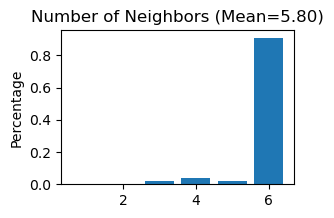

In [12]:
Cal_Spatial_Net(adata, rad_cutoff=150)
Stats_Spatial_Net(adata)

Train model and cluster the embedding 

In [13]:
adata = train_STAGATE(adata)

Size of Input:  (3639, 500)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [12:59<00:00,  1.56s/it]


In [14]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from mclustpy import mclustpy

res = mclustpy(adata.obsm['STAGATE'], G=7, modelNames='EEE', random_seed=2020)
mclust_res = res['classification']
adata.obs['mclust'] = mclust_res
obs_df = adata.obs.dropna()
NMI = normalized_mutual_info_score(obs_df['mclust'],  obs_df['layer'])
print(NMI)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
0.5986729315184208


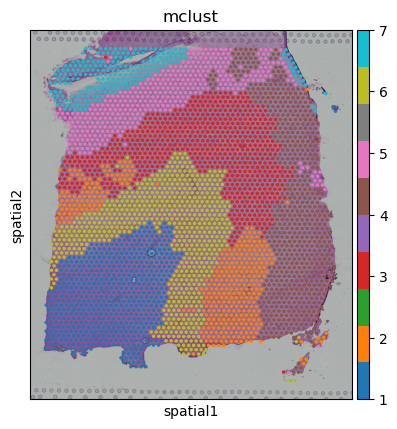

In [15]:
sc.pl.spatial(adata, color='mclust', cmap='tab10')